# Maximum Likelihood Estimation State Tomography Demo

## Install libraries to runtime

If running in Google Colab, run the following setup cell once each time you open your project in order to install non-default package dependencies to the runtime. DO NOT RUN if you have already created a kernel with `qsttoolkit` as per the setup instructions in `README.md`.

In [ ]:
!pip install qsttoolkit

## Imports

All of QSTToolkit's features can be accessed by importing `qsttoolkit` and calling them directly. Most features sit within two main subpackages: `.data` and `.tomography`. In this example notebook, functions are called from their subpackage where relevant to show which features sit in each subpackage, and which lie in modules outside either:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import qsttoolkit as qst

## Data Preparation

We start by defining the dimensionality of our system as `dim`, and the phase space grid for our measurement data - Husimi Q function representations of the states in phase space. This grid is defined to be `data_dim` x `data_dim`:

In [2]:
dim = 32
data_dim = 32                 # Dimensions of the phase space grid that will serve as the image size for our data
xgrid = np.linspace(-5, 5, data_dim)
pgrid = np.linspace(-5, 5, data_dim)

We first create test state density matrices of seven different varieties using the [QuTiP](https://qutip.org/docs/4.0.2/index.html) framework. The first three states can be produced directly using QuTiP functions, the other four are specific superpositions of Fock and coherent states and are produced using custom functions in `qsttoolkit.data`:

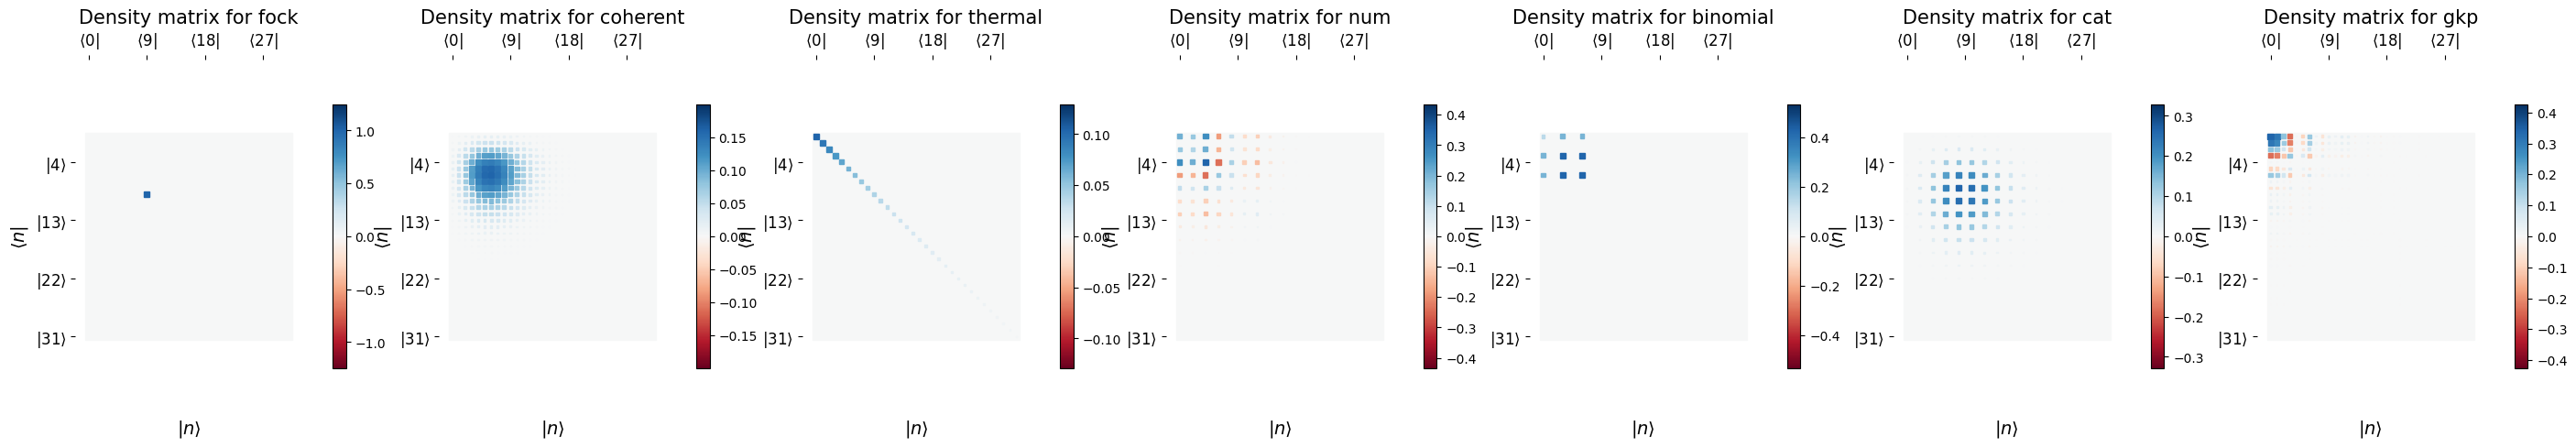

In [ ]:
fock_test = qt.fock_dm(dim, 9)
coherent_test = qt.coherent_dm(dim, 2.5)
thermal_test = qt.thermal_dm(dim, 9)
num_test = qst.data.num_dm('M2', dim)
binomial_test = qst.data.binomial_dm(dim, 2, 2, 1)
cat_test = qst.data.cat_dm(dim, 3)
gkp_test = qst.data.gkp_dm(dim, [-5, 5], [-5, 5], 0.5, 4.5)

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
qst.plot_Hinton(fock_test, ax=ax[0], label='fock')
qst.plot_Hinton(coherent_test, ax=ax[1], label='coherent')
qst.plot_Hinton(thermal_test, ax=ax[2], label='thermal')
qst.plot_Hinton(num_test, ax=ax[3], label='num')
qst.plot_Hinton(binomial_test, ax=ax[4], label='binomial')
qst.plot_Hinton(cat_test, ax=ax[5], label='cat')
qst.plot_Hinton(gkp_test, ax=ax[6], label='gkp')
plt.show()

We create the measurement operators for displace-and-measure phase space Husimi Q measurements of quantum states using `qsttoolkit.tomography.measurement_operators()`:

In [4]:
measurement_operators = qst.tomography.measurement_operators(dim, 'Husimi_Q', xgrid=xgrid, pgrid=pgrid)

We choose our test_state and apply mixed state noise, and then create, format and reshape the Husimi Q measurement data. Redefine `test_state` below with the different states created above:

In [5]:
test_state = qst.mixed_state_noise(num_test, 0.2).full()
expectation_values = qst.expectation(test_state, measurement_operators)
measurement_data = expectation_values.numpy().reshape(1, data_dim**2)           # Reshape the expectation values to a 1D array

## Modelling

We create an instance of the `qsttoolkit.tomography.MLEQuantumStateTomography` class, which handles the setup, performing and evaluation of the optimisation:

In [6]:
MLE_reconstructor = qst.tomography.MLEQuantumStateTomography()

Optimisation of the density matrix parameterisation using the `.reconstruct` method:

In [7]:
MLE_reconstructor.reconstruct(measurement_data,
                              measurement_operators,
                              initial_dm=qst.maximally_mixed_state_dm(dim).full(),     # MLE requires a 'starting guess'
                              epochs=1000,
                              verbose_interval=100,
                              num_progress_saves=10,        # Save the progress of the training
                              true_dm=test_state)           # For calculating the fidelity of the reconstructed during training

Epoch 0/1000, Loss: 65.66799818350951, Fidelity: 0.291183852467889
Epoch 100/1000, Loss: 53.33462675157243, Fidelity: 0.5141784290852495
Epoch 200/1000, Loss: 53.205557288084165, Fidelity: 0.6133036405724246
Epoch 300/1000, Loss: 53.151004657508196, Fidelity: 0.6714270853859092
Epoch 400/1000, Loss: 53.122333940931185, Fidelity: 0.7097365101173891
Epoch 500/1000, Loss: 53.109959562495106, Fidelity: 0.7308852825598879
Epoch 600/1000, Loss: 53.103596590945614, Fidelity: 0.7434244599560659
Epoch 700/1000, Loss: 53.100087888398356, Fidelity: 0.7531028890934374
Epoch 800/1000, Loss: 53.0985555330311, Fidelity: 0.7599635496533231
Epoch 900/1000, Loss: 53.097788457794664, Fidelity: 0.7649922628117989
Reconstruction complete.


## Analysis

Model statistics over optimisation progress:

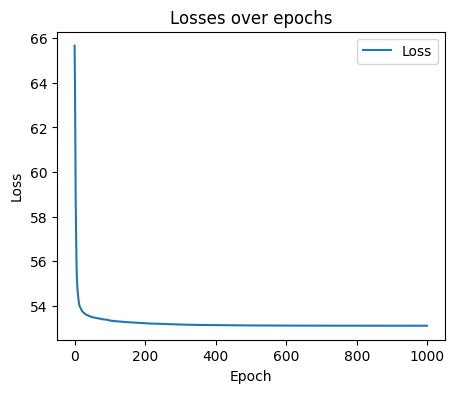

In [8]:
MLE_reconstructor.plot_losses()

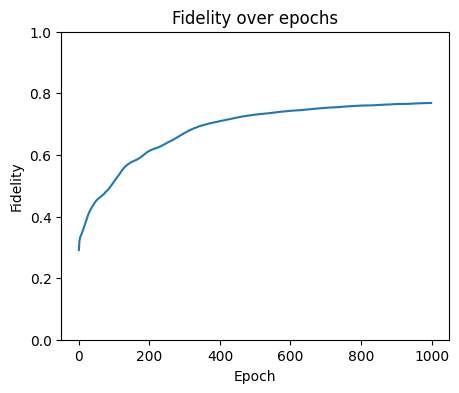

In [9]:
MLE_reconstructor.plot_fidelities()

Comparison of the true and reconstructed states:

In [10]:
print(f"State fidelity: {qst.fidelity(test_state, MLE_reconstructor.reconstructed_dm)}")

State fidelity: 0.7688816989572679


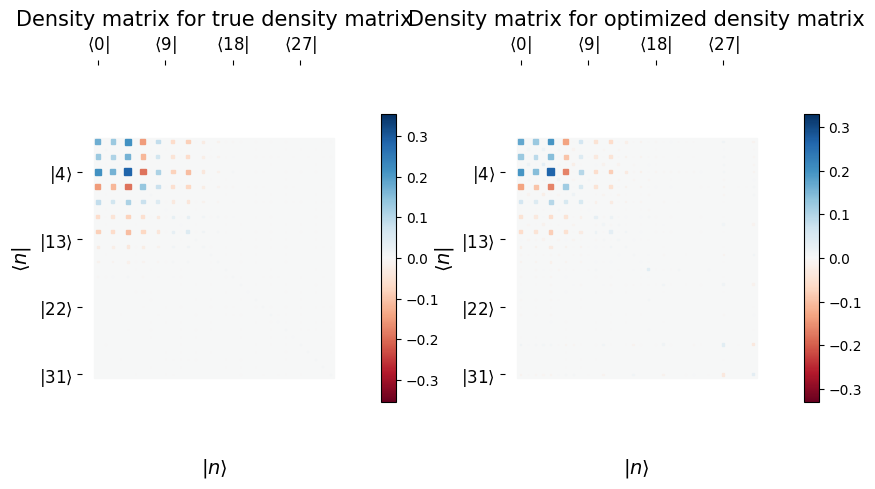

In [ ]:
MLE_reconstructor.plot_comparison_Hintons(test_state)

Comparison of the original test data, and data sampled from the reconstructed state:

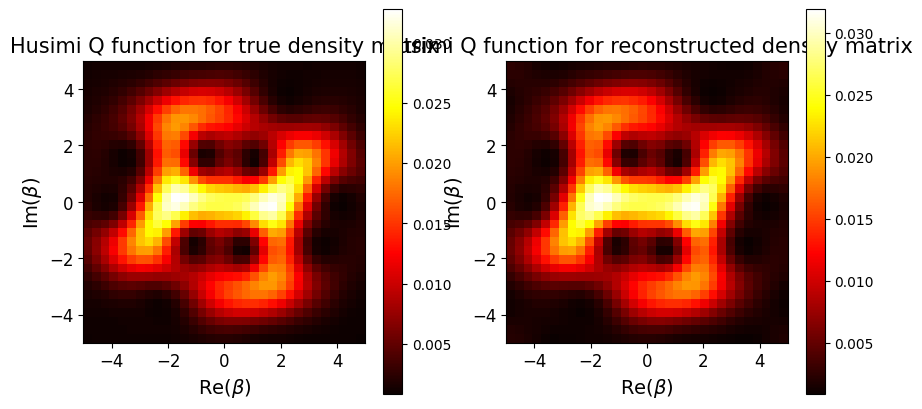

In [12]:
MLE_reconstructor.plot_comparison_Husimi_Qs(test_state, xgrid, pgrid)

Inspection of reconstructions from intermediate parametrizations during optimisation:

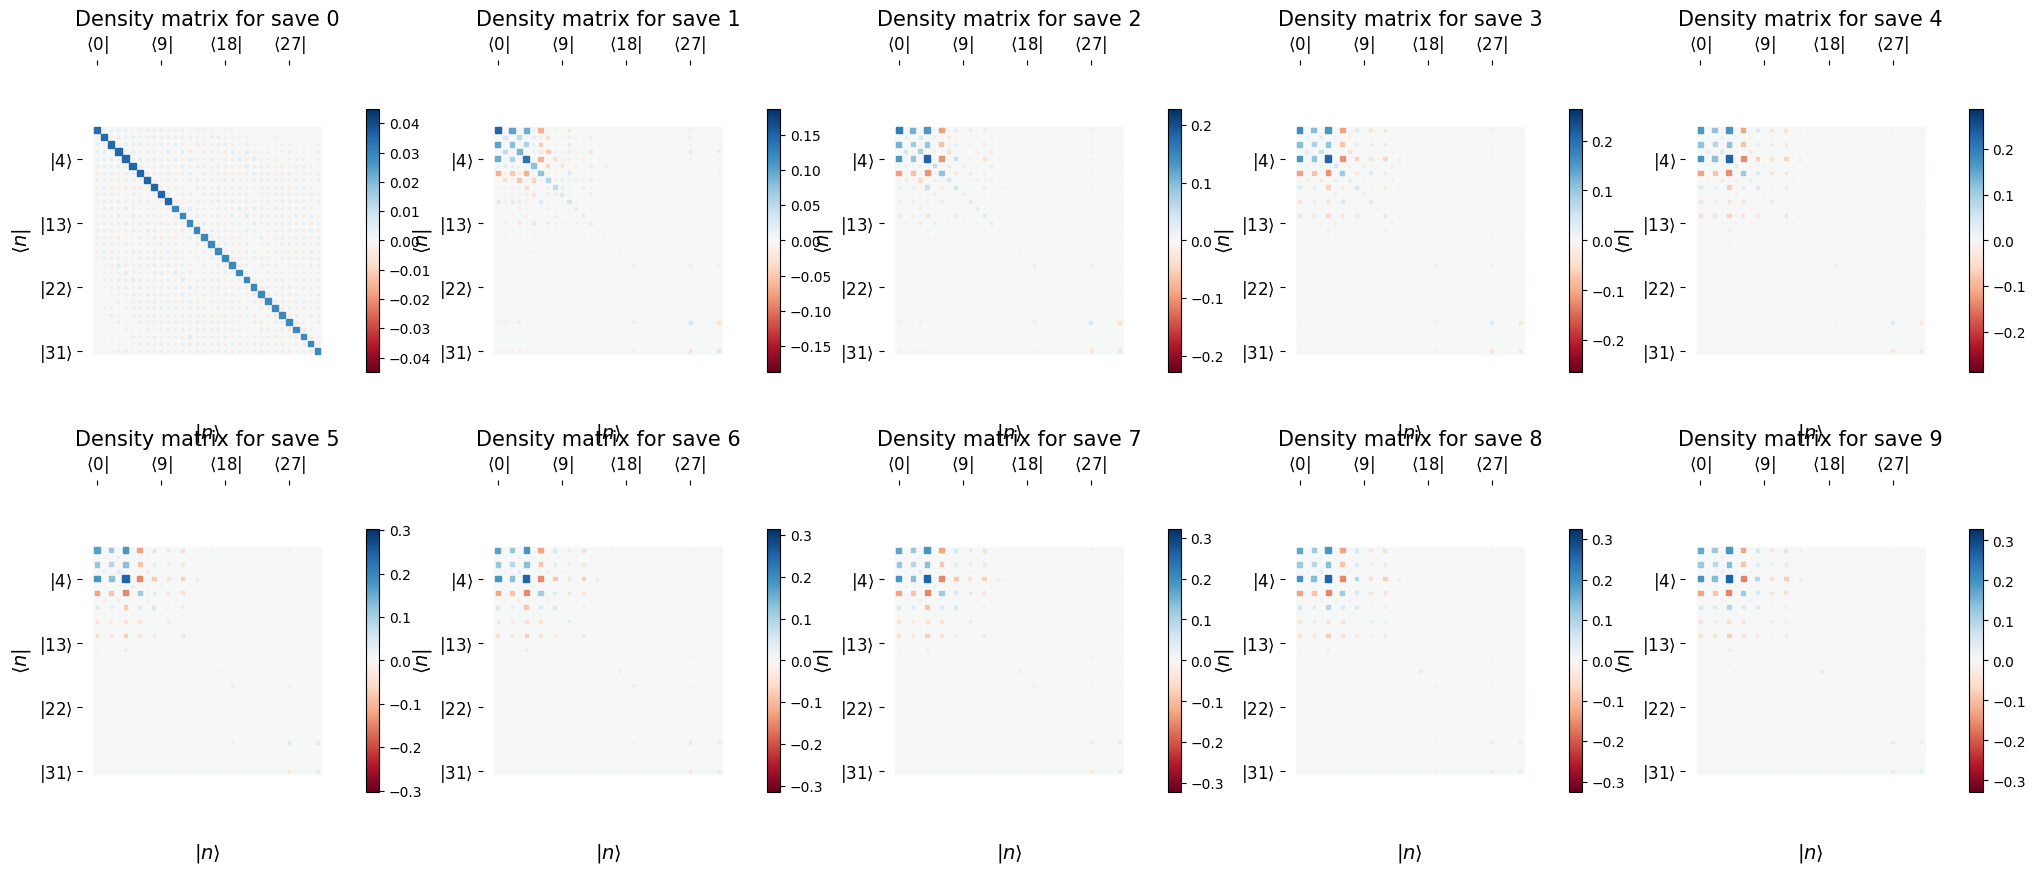

In [ ]:
MLE_reconstructor.plot_intermediate_Hintons()

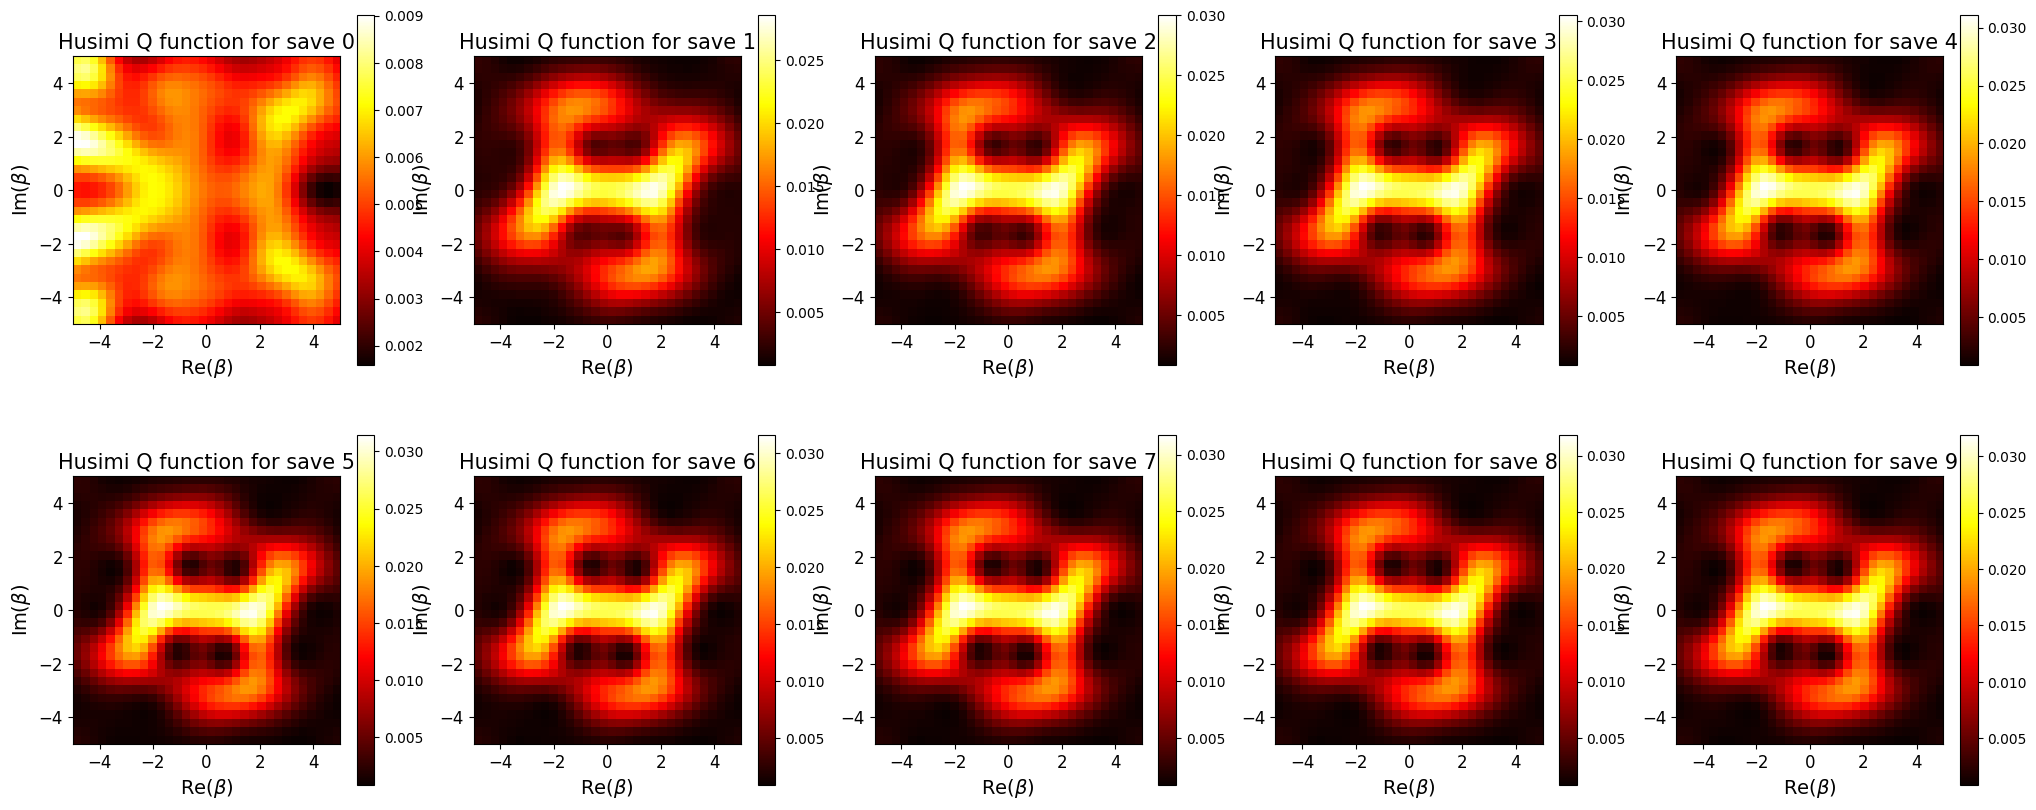

In [14]:
MLE_reconstructor.plot_intermediate_Husimi_Qs(xgrid, pgrid)